### This notebook is to be ran after running classify_pyr_int.m in matlab.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import math
import seaborn as sns
import sys
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
import re
from scipy.ndimage import gaussian_filter1d


Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'


import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [3]:
waves_zscore = np.load(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\waves_zscore.npy')
acg_narrow = np.load(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\acg_narrow.npy')
df_cell_class = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/cell_recruitment/processed/pyr_int_df.csv')
df_cell_class


,session,tetrode,cell,acg_tau_decay,acg_tau_rise,acg_c,acg_d,acg_asymptote,acg_refrac,acg_tau_burst,...,ab_ratio,trough,spkW,short_isi,lv,cv,avg_fr,asymmetry,n_spikes,cell_type
0,LEM3116_S20180715121821,TT1.mat,1,31.546309,0.573929,7.484840,1.810424,4.267133,3.757487,0.577317,...,-0.254493,-2.393640,0.777777,0.021529,1.149097,1.535871,2.529014,3.181064,7340,narrow_int
1,LEM3116_S20180715121821,TT1.mat,2,2.066006,2.058184,99.344603,1.086215,2.731016,7.293023,2.071859,...,1.090940,-2.027969,0.930761,0.010545,1.041924,1.479007,0.392445,1.947498,1139,pyr
2,LEM3116_S20180715121821,TT2.mat,1,26.506166,0.781068,15.805209,1.504109,4.955974,4.657924,0.788345,...,-0.322934,-2.491995,0.777777,0.041928,1.235779,1.773778,2.580697,3.908416,7490,narrow_int
3,LEM3116_S20180715121821,TT3.mat,1,4.712647,3.339123,44.065945,3.111166,0.573573,1.285490,0.985114,...,0.015098,-2.784299,0.571703,0.000555,1.032228,0.999013,0.621228,3.730098,1803,narrow_int
4,LEM3116_S20180715121821,TT3.mat,2,69.711440,1.119072,2.272114,4.029701,6.440918,4.588725,1.144437,...,-0.113610,-2.683800,0.684153,0.011062,0.983793,1.406165,2.959360,3.743105,8589,narrow_int
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8508,RH16_S20161207130000,TT7.mat,5,13.648150,19.260993,4.054789,2.763695,3.311529,0.086722,4.997810,...,-0.270218,-2.886261,0.529358,0.000000,1.059228,5.973929,0.789008,4.629547,1252,narrow_int
8509,RH16_S20161207130000,TT7.mat,6,465.286016,6.540656,9.476762,1.811303,12.260592,0.000135,5.000000,...,-0.289104,-3.028445,0.271706,0.004489,0.735687,23.134516,13.056442,2.818769,20718,narrow_int
8510,RH16_S20161207130000,TT8.mat,1,40.117754,49.985020,7.880123,1.435894,3.685590,0.000087,0.100000,...,-0.916189,-2.461559,0.286010,0.000000,0.955257,6.281825,0.626417,21.188431,994,narrow_int
8511,RH16_S20161207130000,TT8.mat,2,5.123286,5.122541,5.461216,5.218173,9.395189,0.011953,4.965692,...,-0.145166,-2.361157,0.701930,0.021382,0.999326,31.814075,1.533272,2.350860,2433,narrow_int


### add area to data frame

In [4]:
channel_list = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\channel_list.csv')

area = []
for cell in df_cell_class.itertuples():
    # extract tetrode number
    m=re.search('TT(.+?).mat', cell.tetrode)
    tetrode = int(m.group(1))
    idx = (channel_list.session == cell.session) & (channel_list.channel == tetrode)
    if any(idx):
        area.append(channel_list[idx].area.iloc[0])
    else:
        area.append(np.nan)

df_cell_class['area'] = area
df_cell_class

,session,tetrode,cell,acg_tau_decay,acg_tau_rise,acg_c,acg_d,acg_asymptote,acg_refrac,acg_tau_burst,...,trough,spkW,short_isi,lv,cv,avg_fr,asymmetry,n_spikes,cell_type,area
0,LEM3116_S20180715121821,TT1.mat,1,31.546309,0.573929,7.484840,1.810424,4.267133,3.757487,0.577317,...,-2.393640,0.777777,0.021529,1.149097,1.535871,2.529014,3.181064,7340,narrow_int,ca1
1,LEM3116_S20180715121821,TT1.mat,2,2.066006,2.058184,99.344603,1.086215,2.731016,7.293023,2.071859,...,-2.027969,0.930761,0.010545,1.041924,1.479007,0.392445,1.947498,1139,pyr,ca1
2,LEM3116_S20180715121821,TT2.mat,1,26.506166,0.781068,15.805209,1.504109,4.955974,4.657924,0.788345,...,-2.491995,0.777777,0.041928,1.235779,1.773778,2.580697,3.908416,7490,narrow_int,ca1
3,LEM3116_S20180715121821,TT3.mat,1,4.712647,3.339123,44.065945,3.111166,0.573573,1.285490,0.985114,...,-2.784299,0.571703,0.000555,1.032228,0.999013,0.621228,3.730098,1803,narrow_int,ca1
4,LEM3116_S20180715121821,TT3.mat,2,69.711440,1.119072,2.272114,4.029701,6.440918,4.588725,1.144437,...,-2.683800,0.684153,0.011062,0.983793,1.406165,2.959360,3.743105,8589,narrow_int,ca1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8508,RH16_S20161207130000,TT7.mat,5,13.648150,19.260993,4.054789,2.763695,3.311529,0.086722,4.997810,...,-2.886261,0.529358,0.000000,1.059228,5.973929,0.789008,4.629547,1252,narrow_int,ca1
8509,RH16_S20161207130000,TT7.mat,6,465.286016,6.540656,9.476762,1.811303,12.260592,0.000135,5.000000,...,-3.028445,0.271706,0.004489,0.735687,23.134516,13.056442,2.818769,20718,narrow_int,ca1
8510,RH16_S20161207130000,TT8.mat,1,40.117754,49.985020,7.880123,1.435894,3.685590,0.000087,0.100000,...,-2.461559,0.286010,0.000000,0.955257,6.281825,0.626417,21.188431,994,narrow_int,ca1
8511,RH16_S20161207130000,TT8.mat,2,5.123286,5.122541,5.461216,5.218173,9.395189,0.011953,4.965692,...,-2.361157,0.701930,0.021382,0.999326,31.814075,1.533272,2.350860,2433,narrow_int,ca1


### classify cells

In [5]:
df_cell_class.cell_type = 'unidentified'
df_cell_class.loc[(df_cell_class.spkW < .5), "cell_type"] = 'int'
df_cell_class.loc[(df_cell_class.spkW > .5) & (df_cell_class.spkW < 3), "cell_type"] = 'pyr'
# There are some odd waveforms due to neuralynx spike detection
# here, I split the unidentified by ab ratio which seems produce two unique classes of autocorrs (burst & regular spiking)
df_cell_class.loc[(df_cell_class.cell_type=='unidentified') & (df_cell_class.ab_ratio>0), "cell_type"] = 'int'
df_cell_class.loc[(df_cell_class.cell_type=='unidentified') & (df_cell_class.ab_ratio<0), "cell_type"] = 'pyr'

### export csv with cell class with new variables (area & cell_type)

In [6]:
df_cell_class.to_csv(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\pyr_int_df.csv')

### Only keep ca1 and ca3 for plotting and comparisons

In [7]:
idx = (df_cell_class['area'] == 'ca1') | (df_cell_class['area'] == 'ca3')

df_cell_class = df_cell_class[idx]
acg_narrow = acg_narrow[idx]
waves_zscore = waves_zscore[idx]

### flip waveforms that need to be flipped for plots

I used a polarity measure to initially orient them, but the very symmetric waveforms cause some issues.

Here I look aroud where I expect the trough to be. If that spot has a peak, I'll flip it.

In [8]:
max_idx = [np.argmax(np.abs(w)) for w in waves_zscore]

peaks = []
for w in waves_zscore:
    peak,_ = find_peaks(w)
    peaks.append(peak)
to_flip = [np.any((w >= 28-1) & (w<=28+1)) for w in peaks]
waves_zscore_flipped = waves_zscore.copy()
waves_zscore_flipped[to_flip] = waves_zscore_flipped[to_flip]*-1

### make histrogram of spike duration

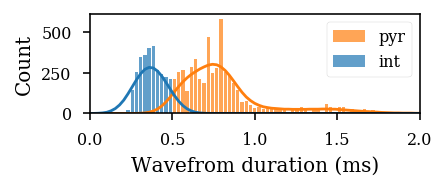

In [10]:
cmap = plt.get_cmap("tab10")

ax = plt.figure(figsize=set_size('thesis', fraction=0.5, subplots=(1,2)), edgecolor='k')

hist,bin_edges=np.histogram(df_cell_class.spkW[df_cell_class.cell_type=='pyr'],bins=np.arange(0,2,.025))
bin_centers = np.linspace(0, 2, len(hist))
smooth_hist = gaussian_filter1d(hist, 3)
plt.bar(bin_centers,hist,width=.02,alpha=.7,color=cmap(1),label='pyr')
plt.plot(bin_centers,smooth_hist,color=cmap(1))

hist,bin_edges = np.histogram(df_cell_class.spkW[df_cell_class.cell_type=='int'],bins=np.arange(0,2,.025))
bin_centers = np.linspace(0, 2, len(hist))
smooth_hist = gaussian_filter1d(hist, 3)
plt.bar(bin_centers,hist,width=.02,alpha=.7,color=cmap(0),label='int')
plt.plot(bin_centers,smooth_hist,color=cmap(0))
plt.xlim(0,2)
plt.xlabel('Wavefrom duration (ms)')
plt.ylabel('Count')

plt.legend()

save_path = "D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/"
plt.savefig(save_path+'waveform_duration.svg',dpi=300,bbox_inches='tight')

### make waveforms and acg plots

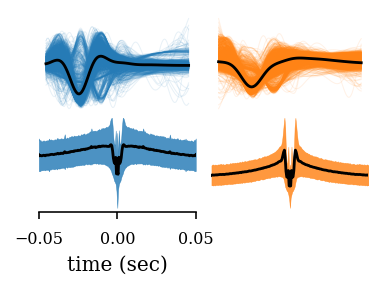

In [11]:
labels = df_cell_class.cell_type
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(2,2, figsize=set_size('thesis', fraction=.5, subplots=(2,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.1)
axs = axs.ravel()

axs[0].plot(waves_zscore_flipped[labels=='int'].T,alpha = .1,color=cmap(0),linewidth=.5)
axs[0].axis('off')
axs[0].set_rasterized(True)
axs[0].plot(np.mean(waves_zscore_flipped[labels=='int'],axis=0),color='k')


axs[1].plot(waves_zscore_flipped[labels=='pyr'].T,alpha = .1,color=cmap(1),linewidth=.5)
axs[1].axis('off')
axs[1].set_rasterized(True)
axs[1].plot(np.mean(waves_zscore_flipped[labels=='pyr'],axis=0),color='k')


temp_acg = acg_narrow[labels=='int'] 
temp_acg = preprocessing.normalize(temp_acg)
x = np.arange(-.05,.05+0.0005/2,0.0005)
y = np.mean(temp_acg,axis=0)
std = np.std(temp_acg,axis=0)
axs[2].fill_between(x, y-std, y+std,color=cmap(0),alpha=.8)
axs[2].plot(x,y,'k')
axs[2].set_xlim(-.05,0.05)
axs[2].axes.get_yaxis().set_ticks([])
axs[2].set_xlabel('time (sec)')

temp_acg = acg_narrow[labels=='pyr'] 
temp_acg = preprocessing.normalize(temp_acg)
x = np.arange(-.05,.05+0.0005/2,0.0005)
y = np.mean(temp_acg,axis=0)
std = np.std(temp_acg,axis=0)
axs[3].fill_between(x, y-std, y+std,color=cmap(1),alpha=.8)
axs[3].plot(x,y,'k')
axs[3].set_xlim(-.05,0.05)
axs[3].axes.get_yaxis().set_ticks([])
axs[3].axis('off')

for i in range(4):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].spines["top"].set_visible(False)


save_path = "D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/"
plt.savefig(save_path+'waveform_acg.svg',dpi=300,bbox_inches='tight')

### make proportion plots

In [12]:
def add_group_affiliation(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx, "group"] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx, "group"] = 'pae'
    return df
    
df_cell_class = add_group_affiliation(df_cell_class)

<ipython-input-12-17608247509a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = np.ones_like(df.session)
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


### get proportion of cell class per area per group

In [13]:
temp_df = df_cell_class[df_cell_class.area == 'ca1']
class_counts_ca1 = pd.crosstab(temp_df.cell_type, temp_df.group,
                rownames=['cell classification'],
                colnames=['group']).apply(lambda r: r/r.sum(), axis=0).stack().reset_index().rename(columns={0:'value'})
class_counts_ca1['area'] = 'ca1'

temp_df = df_cell_class[df_cell_class.area == 'ca3']
class_counts_ca3 = pd.crosstab(temp_df.cell_type, temp_df.group,
                rownames=['cell classification'],
                colnames=['group']).apply(lambda r: r/r.sum(), axis=0).stack().reset_index().rename(columns={0:'value'})
class_counts_ca3['area'] = 'ca3'

class_counts = pd.concat([class_counts_ca1, class_counts_ca3])

class_counts

,cell classification,group,value,area
0,int,control,0.305699,ca1
1,int,pae,0.400000,ca1
2,pyr,control,0.694301,ca1
3,pyr,pae,0.600000,ca1
0,int,control,0.240409,ca3
1,int,pae,0.395107,ca3
2,pyr,control,0.759591,ca3
3,pyr,pae,0.604893,ca3


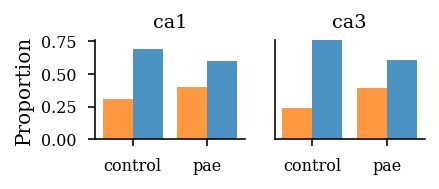

In [14]:
f, ax = plt.subplots(1,2,figsize=set_size('thesis', fraction=.5, subplots=(1, 2)))
fig.subplots_adjust(hspace = 0, wspace=0)
ax = ax.ravel()
max_value = max(class_counts.value)

# cmap = plt.get_cmap("tab10",4)
sns.set_palette(palette=["#FF7F0E",'#1F77B4','#2CA02C','#D3D3D3'])
sns.barplot(x="group", y="value",hue = "cell classification", data=class_counts[class_counts.area=='ca1'],order=['control','pae'],ax=ax[0],saturation=1,alpha=.8)
ax[0].legend([],[], frameon=False)
ax[0].set(ylabel="Proportion")
# sns.despine(trim=False, left=True)
ax[0].set_ylim(0,max_value)
ax[0].set_title('ca1')
ax[0].set_xlabel('')
ax[0].set_yticks(np.arange(0,max_value,.25))


sns.set_palette(palette=["#FF7F0E",'#1F77B4','#2CA02C','#D3D3D3'])
g = sns.barplot(x="group", y="value",hue = "cell classification", data=class_counts[class_counts.area=='ca3'],order=['control','pae'],ax=ax[1],saturation=1,alpha=.8)
ax[1].legend([],[], frameon=False)
ax[1].set(ylabel="Proportion")
ax[1].axes.get_yaxis().set_ticks([])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_ylim(0,max_value)
ax[1].set_title('ca3')
# ax[1].spines["left"].set_visible(False)
sns.despine(trim=False, right=True)

save_path = "D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/"
plt.savefig(save_path+'cell_class_prop.svg',dpi=300,bbox_inches='tight')

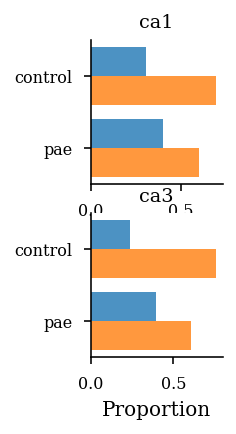

In [15]:
f, ax = plt.subplots(2,1,figsize=set_size('thesis', fraction=.2, subplots=(4, 1)))
fig.subplots_adjust(hspace = 0, wspace=0)
ax = ax.ravel()

max_value = max(class_counts.value)

sns.set_palette(palette=['#1F77B4',"#FF7F0E",'#2CA02C','#D3D3D3'])
sns.barplot(y="group", x="value",hue = "cell classification", data=class_counts[class_counts.area=='ca1'],order=['control','pae'],ax=ax[0],saturation=1,alpha=.8)
ax[0].legend([],[], frameon=False)
ax[0].set_title('ca1')
ax[0].set_ylabel('')
ax[0].set_xlabel('')

# ax[0].axes.get_xaxis().set_ticks([])


g = sns.barplot(y="group", x="value",hue = "cell classification", data=class_counts[class_counts.area=='ca3'],order=['control','pae'],ax=ax[1],saturation=1,alpha=.8)
ax[1].legend([],[], frameon=False)
ax[1].set(xlabel="Proportion")
ax[1].set_ylabel('')
ax[1].set_title('ca3')


sns.despine(trim=False, right=True)

save_path = "D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/"
plt.savefig(save_path+'cell_class_prop_v2.svg',dpi=300,bbox_inches='tight')

In [ ]:
from scipy import stats

temp_df = df_cell_class[df_cell_class.area == 'ca1']
chi2, p, dof, expctd = stats.chi2_contingency(pd.crosstab(temp_df.cell_type, temp_df.group, 
                rownames=['cell_type'], 
                colnames=['group']))

print(chi2)
print(p)
print(dof)
print(expctd)
